# SAP SSFS

The following subsections show a representation of the file format portions and how to generate them.

First we need to perform some setup to import the packet classes:

In [23]:
from pysap.SAPSSFS import *
from pysap.utils.crypto import rsec_decrypt
from IPython.display import display

## SSFS files

We'll read the key and data files used in the test case suite and use them as example:

In [24]:
with open("../../tests/data/ssfs_hdb_dat", "rb") as fd:
    data = fd.read()
    
ssfs_data = SAPSSFSData(data)

with open("../../tests/data/ssfs_hdb_key", "rb") as fd:
    key = fd.read()

ssfs_key = SAPSSFSKey(key)

SSFS files are comprised of the following main structures:

### SSFS Data

In [25]:
ssfs_data.show()

###[ SAP SSFS Data File ]### 
  \records   \
   |###[ SAP SSFS Data Record ]### 
   |  preamble  = 'RSecSSFsData'
   |  length    = 179
   |  type      = 1
   |  filler1   = ''
   |  key_name  = 'HDB/KEYNAME/DB_CON_ENV                                          '
   |  timestamp = '2019-11-26 16:15:40 UTC'
   |  user      = 'SomeUser                '
   |  host      = 'ubuntu                  '
   |  is_deleted= no
   |  is_stored_as_plaintext= yes
   |  is_binary_data= no
   |  filler2   = ''
   |  hmac      = '\x91\x9c\xbd&>U\xa3\x13\xdb\x11VG\xc0\xbb\x86\x9a:#\x07\x13'
   |  data      = 'Env'
   |###[ SAP SSFS Data Record ]### 
   |  preamble  = 'RSecSSFsData'
   |  length    = 184
   |  type      = 1
   |  filler1   = ''
   |  key_name  = 'HDB/KEYNAME/DB_DATABASE_NAME                                    '
   |  timestamp = '2019-11-26 16:15:40 UTC'
   |  user      = 'SomeUser                '
   |  host      = 'ubuntu                  '
   |  is_deleted= no
   |  is_stored_as_plaintex

As can be observed, a SSFS Data file contains multiple records with different key/value pairs, as well as associated meta data.

Some records contain values stored in plaintext, while others are stored in an encrypted fashion. We'll see a password record, which is stored encrypted:

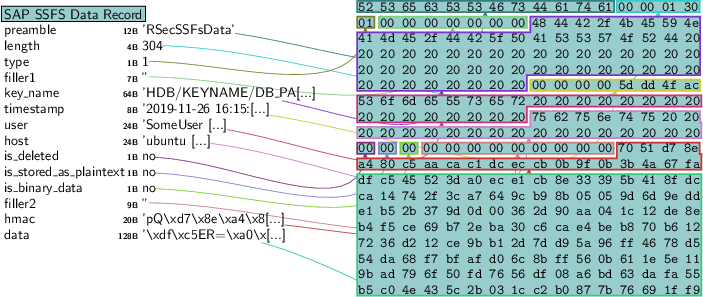

In [26]:
ssfs_data.records[-1].canvas_dump()

Additionally, each SSFS record contains an HMAC-SHA1 value calculated using a fixed key. The intent of this value is to provide integrity validation as well as ensure that an authentic tool was used to generate the files:

In [27]:
ssfs_data.records[-1].valid

True

### SSFS Key content

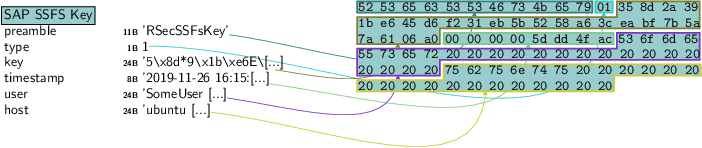

In [28]:
ssfs_key.canvas_dump()

## SSFS Value access

The values contained in SSFS Data records can be accessed by providing the key name:

In [29]:
ssfs_data.get_value('HDB/KEYNAME/DB_USER')

'SomeUser'

### SSFS Data content decryption

For those records that are stored encrypted, it's possible to access the right value by providing the key name and the proper SSFS decryption key structure:

In [30]:
ssfs_data.get_value('HDB/KEYNAME/DB_PASSWORD', ssfs_key)

'SomePassword'

## SSFS Decrypted Payload structure

The decryption mechanism can be user to obtain the raw data stored encrypted:

In [31]:
decrypted_blob = rsec_decrypt(ssfs_data.get_record('HDB/KEYNAME/DB_PASSWORD').data, ssfs_key.key)
decrypted_blob

"lWF\x96`c\xacc\x00\x00\x00\x0c\xfd\x9d<\xde2G\xe0\xf2\x8cE\xddj\xff\x8e\x12\\O\xea6\xc7SomePassword!\x19\xd3\x8d]\xab\xda\xb6\xd3\xc4\xbeK\x0e\x86\x00\xad'\xe6\xff%C.a\xd1vde\x1a\x88,N\xd3\x9e\x87\xab\xc3\xf2'U\xcd\xe2<\xeb65se4j\x0f\xbc\xa5V\xee\xe9M\xbc\xddx>\\\x18\xa9\x87\xdae\x12\xb4\x0c\x86\x89\x0fdG\xde%\xed4\xd7\x02\xf3Z\xed\xb5"

It's possible also to parse that raw data and obtain the underlying strucutures and meta data associated:

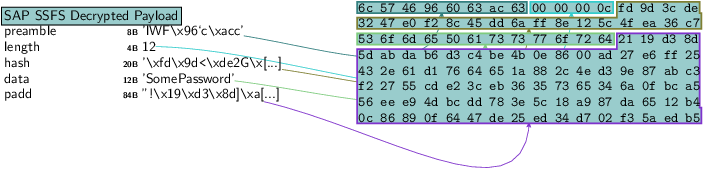

In [32]:
payload = SAPSSFSDecryptedPayload(decrypted_blob)
payload.canvas_dump()

The decrypted payload contains a hash calculated using the SHA-1 algorithm, and that can be used to validate integrity of the entire payload:

In [33]:
payload.valid

True